In [8]:
import xml.etree.cElementTree as etree
import string
import subprocess 
import json
import re
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import operator
from bs4 import BeautifulSoup
import requests

In [3]:
fandomDump = 'harrypotter_pages_current.xml'

In [4]:
base_url = "https://www.hp-lexicon.org/character/?letter="
outfile = "./characters.json"
pages = [ base_url + letter for letter in string.ascii_uppercase ]
characters = []

for page in pages:
    r = requests.get(page)
    r.encoding = 'utf-8'
    page_html = r.content
    soup = BeautifulSoup(page_html, 'html.parser')
    headings = soup.find_all('span',{'itemprop':'headline'})
    for heading in headings:
        characters.append(heading.getText())
    print(f"Downloaded {page}")

with open(outfile, 'w', encoding='utf-8') as f:
    f.write(json.dumps(characters, ensure_ascii=False))

Downloaded https://www.hp-lexicon.org/character/?letter=A
Downloaded https://www.hp-lexicon.org/character/?letter=B
Downloaded https://www.hp-lexicon.org/character/?letter=C
Downloaded https://www.hp-lexicon.org/character/?letter=D
Downloaded https://www.hp-lexicon.org/character/?letter=E
Downloaded https://www.hp-lexicon.org/character/?letter=F
Downloaded https://www.hp-lexicon.org/character/?letter=G
Downloaded https://www.hp-lexicon.org/character/?letter=H
Downloaded https://www.hp-lexicon.org/character/?letter=I
Downloaded https://www.hp-lexicon.org/character/?letter=J
Downloaded https://www.hp-lexicon.org/character/?letter=K
Downloaded https://www.hp-lexicon.org/character/?letter=L
Downloaded https://www.hp-lexicon.org/character/?letter=M
Downloaded https://www.hp-lexicon.org/character/?letter=N
Downloaded https://www.hp-lexicon.org/character/?letter=O
Downloaded https://www.hp-lexicon.org/character/?letter=P
Downloaded https://www.hp-lexicon.org/character/?letter=Q
Downloaded htt

In [45]:
chracters_json = open("characters.json", encoding="utf-8").read()

In [46]:
characters = json.loads(chracters_json)

In [47]:
characterSet = set(map(lambda x: x.lower(), characters))

In [48]:
namespacestr = '{http://www.mediawiki.org/xml/export-0.10/}'
namespace = {'mw': 'http://www.mediawiki.org/xml/export-0.10/'}

In [49]:
# Check if stirng does not contain any world from blacklist
def nonRestricted(string ):
    return True

In [50]:
# Substitu space for _ and cut link
def cleanLink(link):
    split = re.split(r'[|]+', link)
    return split[0]

In [51]:
def findChartersLinks(file_name):
    actorsLinkDic = {}
    for i , (event, elem) in enumerate(etree.iterparse(file_name, events=('start', 'end', 'start-ns', 'end-ns'))):
        # In case that we find tag <page> we continue
        if event == 'end' and elem.tag == namespacestr + 'page':
            # search for tag <title> inside tag <page>
            title = elem.find('.//mw:title', namespace)
            if title is not None: 
                # save text of the title
                title = title.text.lower()
                # search for tag <text> inside tag <page> 
                if title not in characterSet:
                    continue
                textelem = elem.find('.//mw:text', namespace)
                # tag text exist and is not empty and does not contain world from blacklist
                if textelem is not None and textelem.text is not None and nonRestricted(title.lower()):
                    wiki_text=textelem.text
                    lower_wiki_text = wiki_text.lower()
                    # article is not redirect and it is article about character
                    if not "redirect" in lower_wiki_text:
                        link_list = []
                        # find all links in article
                        for link in re.findall(r'\[\[(.*?)\]\]',wiki_text):
                            clink = cleanLink(link).lower()
                            if clink in characterSet:
                                link_list.append(clink)
                        # get metadata from article                  
                        actorsLinkDic[title]=link_list                     
                        
    return actorsLinkDic

In [52]:
# Save dictionary to json
with open('characterLinksDic.json', 'w+') as outfile:
    ActorLinkDic = findChartersLinks(fandomDump)
    json.dump(ActorLinkDic, outfile)

In [53]:
# Create graph from dictionary
with open('characterLinksDic.json', 'r') as outfile:
    characterLinksDic = json.load(outfile)

DG = nx.DiGraph()

# add nodes from dictionary
key_links = set()
for key in characterLinksDic:
    if "potter" in key:
        print("found him", key)
    key_links.add(key)
    DG.add_node(key)
    
# Add edges to graphs
for key, value in characterLinksDic.items():
    for link in value:
        if link in key_links:
            DG.add_edge(key,link)

found him potter family
found him charlus potter
found him albus potter
found him fleamont potter
found him euphemia potter
found him ralston potter
found him lily potter
found him abraham potter


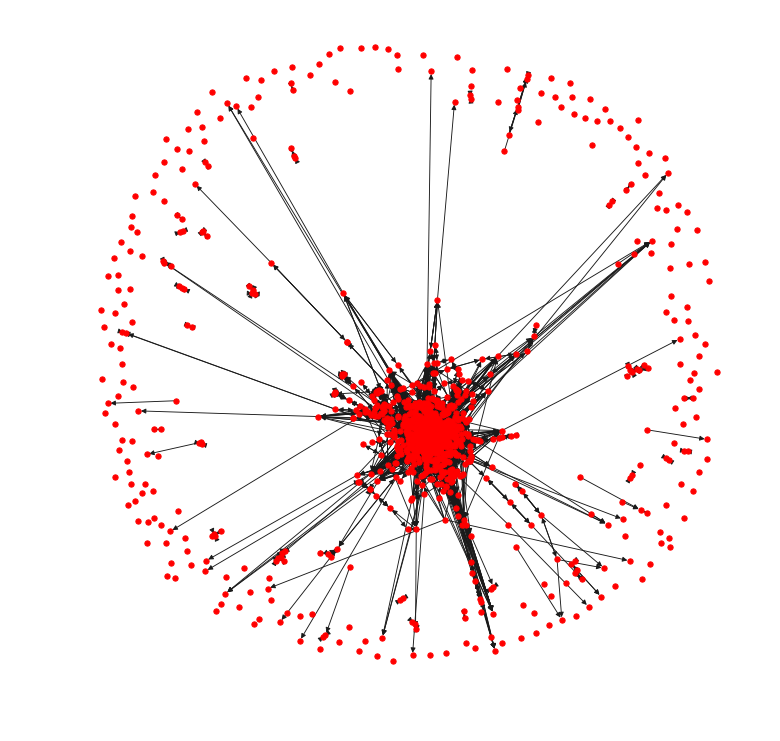

In [54]:
plt.figure(1, figsize=(13, 13))
nx.draw_networkx(DG, node_size=28, edge_color='.1', with_labels=False, width=0.9, font_color ='#ff0000')
plt.axis('off')
plt.show()

In [55]:
G = DG.to_undirected()

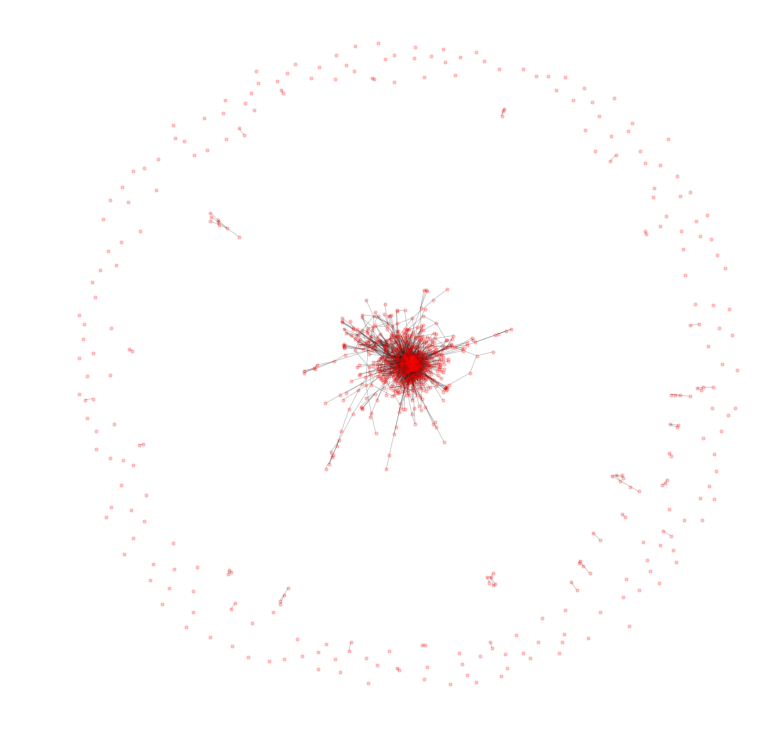

In [56]:
plt.figure(1, figsize=(13, 13))
nx.draw_networkx(G, node_size=10, edge_color='.1', with_labels=False, width=0.9, font_color ='#ff0000', alpha=0.2)
plt.axis('off')
plt.show()

In [57]:
len(DG.nodes)

1041

In [16]:
len(DG.edges)

6583

In [17]:
sorted(DG.degree(), key=lambda kv: kv[1], reverse=True)

[('albus dumbledore', 293),
 ('hermione granger', 275),
 ('severus snape', 174),
 ('draco malfoy', 163),
 ('sirius black', 163),
 ('dolores umbridge', 154),
 ('rubeus hagrid', 153),
 ('neville longbottom', 146),
 ('arthur weasley', 142),
 ('j. k. rowling', 137),
 ('weasley family', 130),
 ('minerva mcgonagall', 129),
 ('luna lovegood', 126),
 ('molly weasley', 124),
 ('bellatrix lestrange', 122),
 ('george weasley', 109),
 ('lucius malfoy', 108),
 ('fred weasley', 107),
 ('albus potter', 102),
 ('horace slughorn', 101),
 ('remus lupin', 97),
 ('nymphadora tonks', 96),
 ('headmaster', 96),
 ('percy weasley', 92),
 ('potter family', 91),
 ('fleur delacour', 90),
 ('angelina johnson', 84),
 ('cedric diggory', 84),
 ('dean thomas', 81),
 ('kingsley shacklebolt', 79),
 ('narcissa malfoy', 75),
 ('cornelius fudge', 73),
 ('phineas nigellus black', 73),
 ('rita skeeter', 72),
 ('filius flitwick', 70),
 ('argus filch', 68),
 ('lee jordan', 67),
 ('seamus finnigan', 66),
 ('katie bell', 65),
 (

1198